<h1>Capstone Project</h1>
<h2>Explore and cluster the neighborhoods in East Kalimantan</h2>

In [68]:
# data analsysis
import pandas as pd 
# HTTP library
import requests 
# convert an address into latitude and longitude values 
from geopy.geocoders import Nominatim 
# map chart
import folium
# data in a vectorized manner manipulation
import numpy as np 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# tranform JSON file
#from pandas.io.json import json_normalize 
# JSON files manipulation
#import json 
# scraping library
#from bs4 import BeautifulSoup 
# sklearn clustering algorithm
#from sklearn.cluster import KMeans 

print('Libraries imported.')

Libraries imported.


In [73]:
df_raw = pd.read_csv('data/kaltim-join-oke-final.csv')
df_raw.drop(df_raw[['Unnamed: 0']], axis=1, inplace=True)

print('The kaltim dataframe shape is', df_raw.shape)
df_raw.head()

The kaltim dataframe shape is (168, 8)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude
0,SANTAN ILIR,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN ILIR, ID 75385",-0.0314,117.49060
1,SANTAN TENGAH,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN TENGAH, ID 75385",-0.0347,117.47890
2,DANAU REDAN,TELUK PANDAN,KUTAI TIMUR,64,75683,"DANAU REDAN, ID 75683",0.0688,117.38410
3,KAHALA,KENOHAN,KUTAI KARTANEGARA,64,75564,"KAHALA, ID 75564",-0.1000,116.36667
4,TANJUNG BATU,DERAWAN (PULAU DERAWAN),BERAU,64,77381,"TANJUNG BATU, ID 77381",-0.1112,117.47180


In [75]:
print('The jakarta dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_raw['sub_district'].unique()),
        df_raw.shape[0]
    )
)

The jakarta dataframe has 63 boroughs and 168 neighborhoods.


In [ ]:
address = 'Kalimantan Timur, ON'

geolocator = Nominatim(user_agent="bdy-application")
location = geolocator.geocode(address, timeout=3)
latitude_kaltim = location.latitude
longitude_kaltim = location.longitude
print('The geograpical coordinate of Kalimantan Timur are {}, {}.'.format(latitude_kaltim, longitude_kaltim))

In [77]:
latitude_kaltim = -0.49991565
longitude_kaltim = 117.131417558709

df_kaltim = df_raw
map_kaltim = folium.Map(location=[latitude_kaltim, longitude_kaltim], zoom_start=7)

# add markers to map
for lat, lng, urban, sub_district in zip(
    df_kaltim['latitude'], 
    df_kaltim['longitude'], 
    df_kaltim['urban'], 
    df_kaltim['sub_district']):
    label = '{}, {}'.format(sub_district, urban)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kaltim)  
    
map_kaltim

The map shows that the Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

Next thing to do is explore each Postcode to get venues using the Foursquare API.

In [78]:
# Foursquare ID
CLIENT_ID = 'RT3CZHJPAA3QVQLSBQMWDKUFWSE44IK5KPUS3CJLUVJ4ZZ0B'
# Foursquare Secret
CLIENT_SECRET = 'KRAUWAKS1FJCWQC0K5U4JPWTMXAUTF4QOGRHSPL3NLUCUPE0'
VERSION = '20181102'

In [79]:
# defining radius and limit of venues
radius = 500
LIMIT = 100

# function
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}' \
            '&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'urban', 
        'urban latitude', 
        'urban Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    return(nearby_venues)

In [81]:
print(df_kaltim.shape)
df_kaltim_tmp = df_kaltim.loc[0:5, :]
df_kaltim_tmp.head()

(168, 8)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude
0,SANTAN ILIR,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN ILIR, ID 75385",-0.0314,117.49060
1,SANTAN TENGAH,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN TENGAH, ID 75385",-0.0347,117.47890
2,DANAU REDAN,TELUK PANDAN,KUTAI TIMUR,64,75683,"DANAU REDAN, ID 75683",0.0688,117.38410
3,KAHALA,KENOHAN,KUTAI KARTANEGARA,64,75564,"KAHALA, ID 75564",-0.1000,116.36667
4,TANJUNG BATU,DERAWAN (PULAU DERAWAN),BERAU,64,77381,"TANJUNG BATU, ID 77381",-0.1112,117.47180


In [28]:
kaltim_venues = getNearbyVenues(
    names = df_kaltim_tmp['urban'],
    latitudes = df_kaltim_tmp['latitude'],
    longitudes = df_kaltim_tmp['longitude']
)

SANTAN ILIR
SANTAN TENGAH
DANAU REDAN
KAHALA
TANJUNG BATU
SATIMPO
SEDULANG
SEBUNTAL
BONTANG BARU
BELIMBING
SIRAU
GUNTUNG
MULAWARMAN
ASA
MUHURAN
SUKAMAJU
MULUPAN
SENDAWAR
MUARA ENGGELAM
TELUK PANDAN
SENYIUR
SEGIHAN
SEPARI
SEMBUAN
EMBALUT
SELERONG
DEMPAR
MINTA
LAHAM
MUARA RITAN
SEDULANG
NGAYAU
PERJIWA
MUARA OHONG
REMPANGA
SIDOREJO
WONOSARI
UJOH BILANG
JEMBAYAN
ANGGANA
MUARA PANTUAN
LONG NAH
SARIJAYA
PENAWAI
PENAWANG
SEKERAT
SEPATIN
KALIORANG
TANJUNG BATU
SUSUK LUAR
KERAITAN
LEMPER
LONG ISUN
SUSUK DALAM
SEPAKU
SENIPAH
KERAYAAN
SAMBUNG
KOLEK
TENDE
BATUAH
TANJUNG MANGKALIHAT
MENTAWIR
PEMALUAN
TELUK SUMBANG
MARIDAN
PAYANG
RIKO
SEPAN
JENEBORA
SOTEK
LAMARU
KARIANGAU
TANJUNG BATU
BARU ULU
SIDOMULYO
SIDODADI
BARU TENGAH
KAMPUNG BARU
SEPINGGAN BARU
DAMAI
BARU ILIR
PENAJAM
PELITA
SEPINGGAN
DAMAI
KLANDASAN ILIR
KLANDASAN ULU
NENANG
PERKUWIN
SESUMPU
PEJALA
PETUNG
WARU
MENDIK
SESULU
BELIMBING
MUNGGU
LABANGKA
RINTIK
LUSAN
KAYUNGO
OLUNG
MARUAT
DUMARING
LOMBOK
TALISAYAN
SEBAKUNG
UKO
MODANG
BUSUI
KASUNGA

In [84]:
kaltim_venues.shape
kaltim_venues.tail()

,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
149,TANJUNG REDEB,2.15281,117.49672,Lopecoffee,2.156114,117.497288,Coffee Shop
150,TANJUNG REDEB,2.15281,117.49672,Bank BRI Kanca Tanjung Redeb,2.155746,117.498520,Bank
151,PULAU DERAWAN,2.28333,118.25000,Derawan Beach Cafe & Cottage,2.283148,118.245572,Resort
152,PULAU DERAWAN,2.28333,118.25000,Cafe Dugong - Derawan Dive Resort,2.282835,118.249497,Snack Place
153,PULAU DERAWAN,2.28333,118.25000,Bumi Manimbora Interbuana Dive Resort,2.282694,118.246349,Harbor / Marina


In [85]:
kaltim_venues.shape
kaltim_venues.to_csv('data/kaltim-venues.csv')

load venues from files

In [86]:
df_raw = pd.read_csv('data/kaltim-venues.csv', encoding = "ISO-8859-1")  
df_raw.drop(['Unnamed: 0'], axis=1, inplace=True)

print('the venues dataframe shape is', df_raw .shape)
df_raw.head()

the venues dataframe shape is (154, 7)


,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SANTAN ILIR,-0.0314,117.4906,Pantai Biru Kersik,-0.033861,117.488182,Beach
1,TANJUNG BATU,-0.1112,117.4718,Marine hall,-0.107978,117.470100,Tennis Court
2,SATIMPO,0.1133,117.4607,Tojasera PT Badak NGL,0.116064,117.463476,Food & Drink Shop
3,SATIMPO,0.1133,117.4607,REGA Cafe & Swimming Pool,0.113037,117.464252,CafÃ©
4,SATIMPO,0.1133,117.4607,Gedung Fitness PT Badak NGL,0.110456,117.463178,Gym / Fitness Center


In [88]:
kaltim_venues = df_raw
print('kaltim venues dataframe shape is', kaltim_venues.shape)
print('There are {} uniques categories.'.format(len(kaltim_venues['Venue Category'].unique())))
kaltim_venues.head()

kaltim venues dataframe shape is (154, 7)
There are 61 uniques categories.


,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SANTAN ILIR,-0.0314,117.4906,Pantai Biru Kersik,-0.033861,117.488182,Beach
1,TANJUNG BATU,-0.1112,117.4718,Marine hall,-0.107978,117.470100,Tennis Court
2,SATIMPO,0.1133,117.4607,Tojasera PT Badak NGL,0.116064,117.463476,Food & Drink Shop
3,SATIMPO,0.1133,117.4607,REGA Cafe & Swimming Pool,0.113037,117.464252,CafÃ©
4,SATIMPO,0.1133,117.4607,Gedung Fitness PT Badak NGL,0.110456,117.463178,Gym / Fitness Center


Analyze Each Neighborhood

In [90]:
# one hot encoding
kaltim_onehot = pd.get_dummies(kaltim_venues[['Venue Category']], prefix="", prefix_sep="")
kaltim_onehot.head()

,Airport Gate,Airport Terminal,Arcade,Asian Restaurant,Bagel Shop,Bakery,Bank,Baseball Field,Beach,Boat or Ferry,...,Resort,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Soup Place,Spa,Steakhouse,Tennis Court
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# add urban column back to dataframe
kaltim_onehot['urban'] = kaltim_venues['urban'] 
# move urban column to the first column
fixed_columns = [kaltim_onehot.columns[-1]] + list(kaltim_onehot.columns[:-1])
kaltim_onehot = kaltim_onehot[fixed_columns]

print('kaltim onehot dataframe shape is', kaltim_onehot.shape)
kaltim_onehot

kaltim onehot dataframe shape is (154, 62)


,urban,Airport Gate,Airport Terminal,Arcade,Asian Restaurant,Bagel Shop,Bakery,Bank,Baseball Field,Beach,...,Resort,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Soup Place,Spa,Steakhouse,Tennis Court
0,SANTAN ILIR,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,TANJUNG BATU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,SATIMPO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SATIMPO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SATIMPO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,SATIMPO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,SEBUNTAL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,BONTANG BARU,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,BONTANG BARU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,BONTANG BARU,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [92]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy.spatial.distance

# scale 
scaler = preprocessing.MinMaxScaler()
kaltim_onehot_kmeans = kaltim_onehot.loc[:, "Airport Gate":"Tennis Court"]
scaler.fit(kaltim_onehot_kmeans)
kaltim_onehot_transformed = scaler.transform(kaltim_onehot_kmeans)
#kaltim_onehot_transformed

# initialize k
distortions = []
inertias = []
K = range(1,15)
X = kaltim_onehot_transformed
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(scipy.spatial.distance.cdist(X, kmeanModel.cluster_centers_,'euclidean'),axis=1))/X.shape[0]) 
    inertias.append(kmeanModel.inertia_)

print('proses complete.')

proses complete.


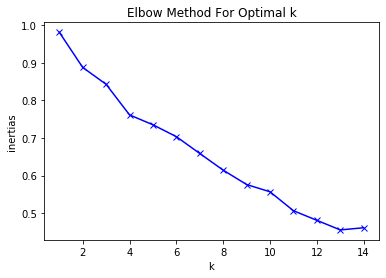

In [93]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('inertias')
#plt.ylabel('distortions')
plt.title('Elbow Method For Optimal k')

plt.show()

group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [125]:
kaltim_grouped = kaltim_onehot.groupby('urban').mean().reset_index()
kaltim_grouped['Total'] = np.count_nonzero(kaltim_grouped, axis=1)

print('kaltim grouped dataframe shape is', kaltim_grouped.shape)
kaltim_grouped.head()

kaltim grouped dataframe shape is (32, 63)


,urban,Airport Gate,Airport Terminal,Arcade,Asian Restaurant,Bagel Shop,Bakery,Bank,Baseball Field,Beach,...,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Snack Place,Soup Place,Spa,Steakhouse,Tennis Court,Total
0,BARU ILIR,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4
1,BARU TENGAH,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3
2,BELIMBING,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,3
3,BONTANG BARU,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4
4,DAMAI,0.0,0.0,0.0,0.090909,0.0,0.045455,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,14


each neighborhood along with the top 5 most common venues

In [121]:
num_top_venues = 5

for hood in kaltim_grouped['urban']:
    print("----"+ hood +"----")
    temp = kaltim_grouped[kaltim_grouped['urban'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BARU ILIR----
            venue  freq
0           Total  4.00
1            Park  0.33
2      Food Truck  0.33
3           CafÃ©  0.33
4  Hardware Store  0.00


----BARU TENGAH----
                  venue  freq
0                 Total   3.0
1     Food & Drink Shop   0.5
2                 Diner   0.5
3  Gym / Fitness Center   0.0
4        Hardware Store   0.0


----BELIMBING----
                venue  freq
0               Total   3.0
1  Seafood Restaurant   0.5
2          Campground   0.5
3          Steakhouse   0.0
4                 Spa   0.0


----BONTANG BARU----
              venue  freq
0             Total  4.00
1  Asian Restaurant  0.33
2     Hot Dog Joint  0.33
3        Restaurant  0.33
4              Park  0.00


----DAMAI----
                   venue   freq
0                  Total  14.00
1  Indonesian Restaurant   0.18
2                  Hotel   0.18
3             Soup Place   0.09
4            Karaoke Bar   0.09


----GUNTUNG----
                venue  freq
0              

new dataframe and display the top 10 venues for each neighborhood.

In [97]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['urban']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['urban'] = kaltim_grouped['urban']

for ind in np.arange(kaltim_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kaltim_grouped.iloc[ind, :], num_top_venues)

print('neighbourhoods venues dataframe shape is', kaltim_grouped.shape)
neighborhoods_venues_sorted.head()

neighbourhoods venues dataframe shape is (32, 62)


,urban,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARU ILIR,Food Truck,CafÃ©,Park,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
1,BARU TENGAH,Food & Drink Shop,Diner,Food Court,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Department Store
2,BELIMBING,Seafood Restaurant,Campground,Tennis Court,CafÃ©,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner
3,BONTANG BARU,Asian Restaurant,Hot Dog Joint,Restaurant,Tennis Court,Campground,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner
4,DAMAI,Indonesian Restaurant,Hotel,Karaoke Bar,Soup Place,Asian Restaurant,Cosmetics Shop,Nightclub,Breakfast Spot,Hardware Store,Miscellaneous Shop


<h2>Run k-means to cluster the neighborhood into 5 clusters.</h2>

In [99]:
# set number of clusters
kclusters = 5
kaltim_grouped_clustering = kaltim_grouped.drop('urban', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kaltim_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [100]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
kaltim_merged = df_kaltim
# merge kaltim_grouped with toronto_data to add latitude/longitude for each neighborhood
kaltim_merged = kaltim_merged.join(neighborhoods_venues_sorted.set_index('urban'), on='urban')

print('kaltim merge dataframe shape is', kaltim_merged.shape)
kaltim_merged.head()

kaltim merge dataframe shape is (168, 19)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SANTAN ILIR,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN ILIR, ID 75385",-0.0314,117.49060,2.0,Beach,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
1,SANTAN TENGAH,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN TENGAH, ID 75385",-0.0347,117.47890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DANAU REDAN,TELUK PANDAN,KUTAI TIMUR,64,75683,"DANAU REDAN, ID 75683",0.0688,117.38410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KAHALA,KENOHAN,KUTAI KARTANEGARA,64,75564,"KAHALA, ID 75564",-0.1000,116.36667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TANJUNG BATU,DERAWAN (PULAU DERAWAN),BERAU,64,77381,"TANJUNG BATU, ID 77381",-0.1112,117.47180,1.0,Harbor / Marina,Boat or Ferry,Scenic Lookout,Pier,Restaurant,Tennis Court,Soup Place,Diner,Donut Shop,Dumpling Restaurant


In [126]:
# add clustering labels
kaltim_grouped_kmeans = kaltim_grouped 
kaltim_grouped_kmeans.insert(0, 'Cluster Labels', kmeans.labels_)
print('field inserted.')

field inserted.


In [130]:
kaltim_grouped_kmeans_tmp = kaltim_grouped_kmeans.loc[:, ['Cluster Labels','urban','Total']]
kaltim_grouped_kmeans_tmp.groupby(['Cluster Labels'])['Total'].sum().reset_index()
#kaltim_grouped_kmeans.head()

,Cluster Labels,Total
0,0,2
1,1,141
2,2,6
3,3,6
4,4,2


In [101]:
kaltim_merged.loc[kaltim_merged['Cluster Labels'].isnull()]

,urban,sub_district,city,province_code,postal_code,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,SANTAN TENGAH,MARANG KAYU,KUTAI KARTANEGARA,64,75385,"SANTAN TENGAH, ID 75385",-0.03470,117.47890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DANAU REDAN,TELUK PANDAN,KUTAI TIMUR,64,75683,"DANAU REDAN, ID 75683",0.06880,117.38410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KAHALA,KENOHAN,KUTAI KARTANEGARA,64,75564,"KAHALA, ID 75564",-0.10000,116.36667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SEDULANG,KOTA BANGUN,KUTAI KARTANEGARA,64,75561,"SEDULANG, ID 75561",0.11667,116.80000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,SEDULANG,MUARA KAMAN,KUTAI KARTANEGARA,64,75553,"SEDULANG, ID 75553",0.11667,116.80000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,SIRAU,LONG HUBUNG,KUTAI BARAT,64,75779,"SIRAU, ID 75779",0.18333,115.51667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,MULAWARMAN,TENGGARONG SEBERANG,KUTAI KARTANEGARA,64,75572,"MULAWARMAN, ID 75572",-0.19480,117.14350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,ASA,BARONG TONGKOK,KUTAI BARAT,64,75776,"ASA, ID 75776",-0.20000,115.63333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,MUHURAN,KOTA BANGUN,KUTAI KARTANEGARA,64,75561,"MUHURAN, ID 75561",-0.20000,116.55000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,MULUPAN,MUARA BENGKAL,KUTAI TIMUR,64,75654,"MULUPAN, ID 75654",0.23333,116.76667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#jakarta_venues
#jakarta_merged
result_merged = kaltim_merged.join(kaltim_venues.set_index('urban'), on='urban')
result_merged_final = result_merged[['Cluster Labels','urban','Venue Category']]
result_merged_final = result_merged_final.fillna(0)
result_merged_final['cluster'] = result_merged_final['Cluster Labels'].astype(int)
result_merged_final.drop(['Cluster Labels'], axis=1, inplace=True)
#result_merged_final.head()

result_groupby = result_merged_final.groupby(['cluster','urban'])['Venue Category'].count()
#result_groupby = result_merged_final.groupby(['cluster','urban','Venue Category'])['Venue Category'].count()
result_groupby


cluster  urban         
0        ANGGANA            1
         ASA                1
         BARU ULU           1
         BATUAH             1
         BENUA BARU         1
         BETUNG             2
         BUSUI              1
         DANAU REDAN        1
         DEMPAR             1
         DUMARING           1
         EMBALUT            1
         GERSIK             1
         GUNUNG PANJANG     2
         JEMBAYAN           1
         KAHALA             1
         KALIORANG          1
         KARIANGAU          1
         KASAI              2
         KASUNGAI           1
         KAYUNGO            1
         KELADEN            1
         KERAITAN           1
         KERANG             1
         KERAYAAN           1
         KOLEK              1
         KUARO              1
         LABANGKA           1
         LABURAN            1
         LAHAM              1
         LEGAI              1
                           ..
1        BARU TENGAH        2
         BELIMBI

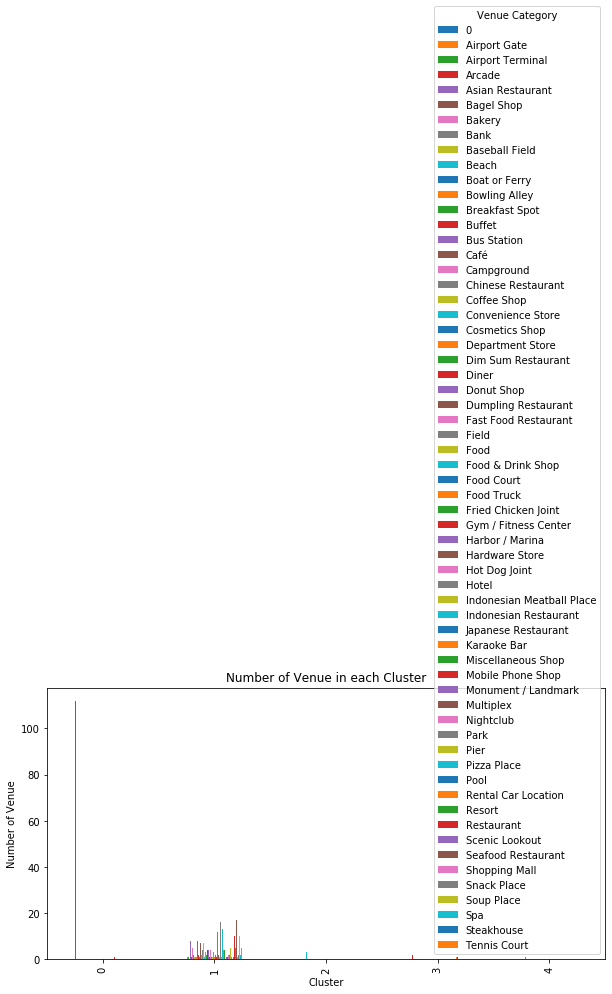

In [58]:
result_merged_final.groupby(['cluster','Venue Category'])['Venue Category'].count().unstack().plot(
    kind='bar', 
    figsize=(10, 5)
)
plt.title('Number of Venue in each Cluster')
plt.ylabel('Number of Venue', fontsize=10)
plt.xlabel('Cluster', fontsize=10)
#plt.xticks(15)
#plt.legend(bbbox_to_anchor=(1,0,5))

plt.show()

visualize the resulting clusters

In [131]:
import math

# create map
map_clusters = folium.Map(location=[latitude_kaltim, longitude_kaltim], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
#kaltim_merged['Cluster Labels'] = kaltim_merged['Cluster Labels'].astype(int)
for lat, lon, poi, cluster in zip(
    kaltim_merged['latitude'], 
    kaltim_merged['longitude'], 
    kaltim_merged['urban'], 
    kaltim_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if np.isnan(cluster - 1):
        n_int = 0
    else:
        n_int = int((cluster - 1))
    #print (n_int)   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[n_int],
        #color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[n_int],
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Examine Clusters</h2>

<h3>cluster 1</h3>

In [132]:
kaltim_merged.loc[
    kaltim_merged['Cluster Labels'] == 0, 
    kaltim_merged.columns[[1] + list(range(5, kaltim_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,PENAJAM,"RIKO, ID 76145",-1.1256,116.6353,0.0,Mobile Phone Shop,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant


<h3>cluster 2</h3>  

In [133]:
kaltim_merged.loc[
    kaltim_merged['Cluster Labels'] == 1, 
    kaltim_merged.columns[[1] + list(range(5, kaltim_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,DERAWAN (PULAU DERAWAN),"TANJUNG BATU, ID 77381",-0.11120,117.47180,1.0,Harbor / Marina,Boat or Ferry,Scenic Lookout,Pier,Restaurant,Tennis Court,Soup Place,Diner,Donut Shop,Dumpling Restaurant
5,TENGGARONG SEBERANG,"TANJUNG BATU, ID 75572",-0.11120,117.47180,1.0,Harbor / Marina,Boat or Ferry,Scenic Lookout,Pier,Restaurant,Tennis Court,Soup Place,Diner,Donut Shop,Dumpling Restaurant
6,BONTANG SELATAN,"SATIMPO, ID 75324",0.11330,117.46070,1.0,CafÃ©,Food Court,Gym / Fitness Center,Food & Drink Shop,Asian Restaurant,Coffee Shop,Food,Airport Terminal,Field,Fast Food Restaurant
9,MARANG KAYU,"SEBUNTAL, ID 75385",-0.11900,117.42970,1.0,Indonesian Meatball Place,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
10,BONTANG UTARA,"BONTANG BARU, ID 75311",0.11940,117.48660,1.0,Asian Restaurant,Hot Dog Joint,Restaurant,Tennis Court,Campground,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner
11,BONTANG BARAT,"BELIMBING, ID 75313",0.14660,117.46550,1.0,Seafood Restaurant,Campground,Tennis Court,CafÃ©,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner
12,LONG IKIS,"BELIMBING, ID 76282",0.14660,117.46550,1.0,Seafood Restaurant,Campground,Tennis Court,CafÃ©,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner
14,BONTANG UTARA,"GUNTUNG, ID 75314",0.18640,117.47670,1.0,Restaurant,Seafood Restaurant,Hotel,Dim Sum Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Department Store,Tennis Court
24,SEBULU,"SEGIHAN, ID 75552",-0.30460,117.02130,1.0,Harbor / Marina,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
41,KOTA BANGUN,"WONOSARI, ID 75561",-0.54470,117.27910,1.0,CafÃ©,Food Court,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant,Department Store


<h3>cluster 3</h3>

In [134]:
kaltim_merged.loc[
    kaltim_merged['Cluster Labels'] == 2, 
    kaltim_merged.columns[[1] + list(range(5, kaltim_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MARANG KAYU,"SANTAN ILIR, ID 75385",-0.0314,117.4906,2.0,Beach,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
76,PENAJAM,"JENEBORA, ID 76146",-1.1854,116.7587,2.0,Beach,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
107,WARU,"SESULU, ID 76284",-1.4061,116.5956,2.0,Beach,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant


<h3>cluster 4</h3>

In [135]:
kaltim_merged.loc[
    kaltim_merged['Cluster Labels'] == 3, 
    kaltim_merged.columns[[1] + list(range(5, kaltim_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,TENGGARONG SEBERANG,"SUKAMAJU, ID 75572",-0.2242,117.0801,3.0,Arcade,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
91,BALIKPAPAN SELATAN,"SEPINGGAN BARU, ID 76115",-1.2415,116.9017,3.0,Restaurant,Arcade,Rental Car Location,Dim Sum Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Department Store,Tennis Court


<h3>cluster 5</h3>

In [136]:
kaltim_merged.loc[
    kaltim_merged['Cluster Labels'] == 4, 
    kaltim_merged.columns[[1] + list(range(5, kaltim_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,PENAJAM,"NENANG, ID 76141",-1.2873,116.7422,4.0,Asian Restaurant,Tennis Court,Campground,Food,Field,Fast Food Restaurant,Dumpling Restaurant,Donut Shop,Diner,Dim Sum Restaurant
